<a href="https://colab.research.google.com/github/alunfes/GoogleColabProjects/blob/main/GARL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from collections import deque
from numba import jit

In [3]:
'''
改善案：
・NNを小さくして効率性を維持するためにstate lengthを128から16とかにしてサンプリングするようにする。
・TradingEnvをjitなどにする。 -> libtorchに行って方がいいか？？
・GAじゃなくてoptunaでやったらどうなるか


検証案：
・学習済みNNパフォーマンス
・NN構造を極端に小さくしてみる。
->50 -> 35秒くらいになった感じ。envが根本的なボトルネック
'''

'\n改善案：\n・NNを小さくして効率性を維持するためにstate lengthを128から16とかにしてサンプリングするようにする。\n・TradingEnvをjitなどにする。 -> libtorchに行って方がいいか？？\n・GAに破壊的再生を入れる。\n\n\n検証案：\n・学習済みNNパフォーマンス\n・NN構造を極端に小さくしてみる。\n->50 -> 35秒くらいになった感じ。envが根本的なボトルネック\n'

In [12]:
################################################################################
########################## Config ####################################
################################################################################
ohlc_directory = '/content/drive/My Drive/MarketData/ohlc'
model_directory = '/content/drive/My Drive/Model/'

In [13]:
################################################################################
########################## MarketData ####################################
################################################################################
class MarketData:
    @classmethod
    def initialize(cls, terms:list):
        cls.terms = terms
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.dt = []
        cls.ma_kairi = {} #term:ma_kairi
        cls.__read_data()
        cls.__calc_all_index()


    @classmethod
    def __read_data(cls):
        df = pd.read_csv(ohlc_directory+'/bybit-USDT-BTC.csv')
        cls.open = df['open'].tolist()
        cls.high = df['high'].tolist()
        cls.low = df['low'].tolist()
        cls.close = np.array(df['close'].tolist())
        cls.dt = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    @classmethod
    def __calc_all_index(cls):
        for term in cls.terms:
            cls.ma_kairi[term] = cls.__calc_ma_kairi(term)

    @classmethod
    def __calc_ma_kairi(cls, term):
        ma = pd.Series(cls.close).rolling(window=term).mean()  # 移動平均を計算
        ma_kairi = ((pd.Series(cls.close) - ma) / ma) * 100  # 乖離率を計算
        ma_kairi[:term] = np.nan  # 最初のterm要素をnanに設定
        return ma_kairi.tolist()

    @classmethod
    def generate_state(cls, current_index, state_length):
        # Ensure the index is within the valid range
        if current_index - state_length < 0 or current_index >= len(cls.close):
            raise ValueError("Invalid current_index for generating market data state.")
        # Extracting the state data
        state = {f'ma_kairi_{term}': np.array(cls.ma_kairi[term][current_index - state_length:current_index])
            for term in cls.terms}
        return state

    @classmethod
    def generate_state2(cls, current_index, desired_state_length, sampled_state_length):
        if current_index < desired_state_length or current_index >= len(cls.close):
            raise ValueError("Invalid current_index for generating market data state.")
        # 開始インデックスの計算
        start_index = max(0, current_index - desired_state_length)
        # 価格変動率の計算
        price_changes = np.diff(cls.close[start_index:current_index])
        change_rates = np.abs(price_changes / cls.close[start_index:current_index - 1])
        # 変動率に基づく重み付け
        weights = np.append(change_rates, [0])  # 最後に0を追加してサイズを合わせる
        weights /= weights.sum()  # 重みの合計が1になるように調整
        # 重みに基づいてサンプリング
        sampled_indices = np.random.choice(range(start_index, current_index), size=sampled_state_length, replace=False, p=weights)
        # サンプリングされたデータの抽出
        state = {f'ma_kairi_{term}': np.array([cls.ma_kairi[term][i] for i in sampled_indices])
                 for term in cls.terms}
        return state

MarketData.initialize([5, 15, 60, 120, 240, 720])

Step 0:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 1:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 2:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 3:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 4:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00,

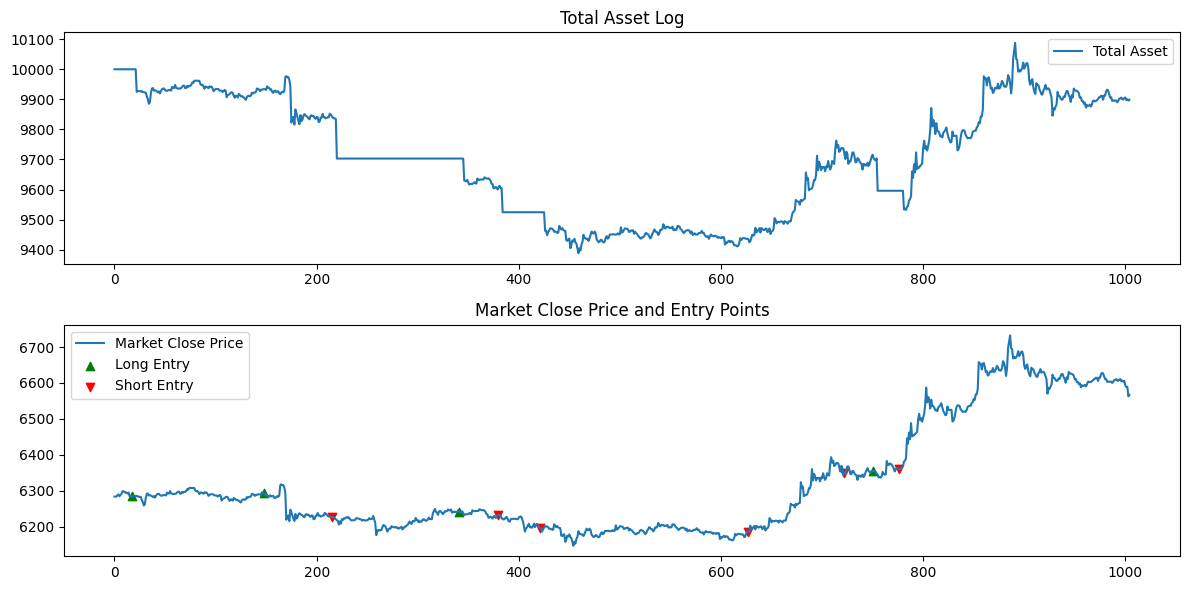

In [30]:
################################################################################
########################## Trading Env ####################################
'''
前提:
・order cash ratioを基準にしており、no posi or additional execの場合はfree cashを基準に、oppsite execの場合はposition lotを基準に計算する。ratioが0.99以上の場合は1.0として処理する。
また、ratioの最大値は1.0、よってfully exit and opposite entryはない前提

Actions:
0: no action
1:long market order
2:short market order
3:long limit order
4:short limit order
5: exit all


memo:
対応が必要な問題点
・is_done時、sim終了時に保有ポジションがあったら強制売買してperformance等に反映すべき。



高速化に関する改善案：
データ構造の最適化: orderをdictにした方がいいらしい
不要なループの削減: __update_order_index メソッドで、毎回全ての注文について処理を行っていますが、実際に必要な処理だけに限定することで計算量を削減できます。
計算のキャッシュ化: 何度も計算される値（例えば__calc_total_asset メソッドで計算される総資産）をキャッシュし、値が変わらない限り再計算しないようにすると、計算効率が向上します。
ログの取り扱い: ログを取る方法（__take_logメソッド）は、リストへの追加操作が多くなると遅くなる可能性があります。必要なログの量を減らすか、データ構造を見直すことで改善できるかもしれません。



'''
################################################################################
class TradingEnv:
    def __init__(self, display_flg, start_ind, end_ind, state_length, is_done_pnl_ratio=-0.2, is_done_trade_ratio=6.9e-04, spread_ratio=0.0005, maker_fee_ratio=0.001, taker_fee_ratio=0.007, effective_digits=2):
        self.display_flg = display_flg
        self.start_ind = start_ind
        self.end_ind = end_ind
        self.state_length = state_length
        self.is_done_pnl_ratio = is_done_pnl_ratio
        self.is_done_trade_ratio = is_done_trade_ratio
        self.initial_asset = 10000
        self.max_orders = 5
        self.spread_ratio = spread_ratio
        self.maker_fee_ratio = maker_fee_ratio
        self.taker_fee_ratio = taker_fee_ratio
        self.effective_digits = effective_digits
        self.reset()

    def __init_position(self):
        self.position_side = 0
        self.position_price = 0
        self.position_lot = 0
        self.position_entry_ind = 0


    def __get_position_size(self):
        return MarketData.close[self.start_ind + self.num_steps] * self.position_lot

    def __init_order(self):
        self.order_side = []
        self.order_price = []
        self.order_cash_ratio = [] #
        self.order_price_close_ratio = 0  # Order price / current price ratio
        self.order_amount_close_ratio = 0  # order amount / current price ratio

    def __init_performance(self):
        self.total_asset = self.initial_asset
        self.total_asset_change_ratio = 0
        self.free_cash = self.initial_asset
        self.total_fee = 0
        self.total_pnl = 0
        self.total_realized_pnl = 0
        self.unrealized_pnl = 0
        self.unrealized_pnl_ratio = 0
        self.position_amount_total_asset_ratio = 0
        self.num_trade = 0
        self.num_win = 0
        self.win_rate = 0
        self.total_asset_when_last_entry = 0

    def __init_log(self):
        self.total_asset_log = [self.initial_asset] * self.state_length
        self.free_cash_log = deque([self.initial_asset] * self.state_length, maxlen=self.state_length)
        self.total_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.total_realized_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.unrealized_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.unrealized_pnl_ratio_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_side_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_price_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_amount_total_asset_ratio_log = deque([0] * self.state_length, maxlen=self.state_length)


    def reset(self):
        self.num_steps = 0
        self.current_action_ind = -1
        self.__init_position()
        self.__init_order()
        self.__init_performance()
        self.__init_log()

    def __check_is_done(self):
        if self.is_done_pnl_ratio > (self.total_asset - self.initial_asset) / self.initial_asset:
            if self.display_flg:
                print('Env is done due to asset change ratio criteria!')
                print('total asset=',self.total_asset, ', asset ratio=', (self.total_asset - self.initial_asset) / self.initial_asset)
            return True
        elif self.is_done_trade_ratio > (self.num_trade+1) / (self.num_steps+1):
            if self.display_flg:
                print('Env is done due to num trade per step criteria!')
                print('num trade=', self.num_trade, ', steps=', self.num_steps)
            return True

    def __calc_unrealized_pnl(self):
        unrealized_pnl = self.position_side * (MarketData.close[self.start_ind + self.num_steps] - self.position_price) * self.position_lot
        return unrealized_pnl

    def __update_performance(self):
        self.unrealized_pnl = self.__calc_unrealized_pnl()
        self.unrealized_pnl_ratio = 0 if self.unrealized_pnl == 0 else self.unrealized_pnl / self.total_asset_when_last_entry
        self.win_rate = 0 if self.num_trade == 0 else self.num_win / self.num_trade
        self.position_amount_total_asset_ratio = (self.position_lot * self.position_price) / self.total_asset
        self.total_asset = self.__calc_total_asset()  # Assuming there is a method __calc_total_asset
        self.total_asset_change_ratio = (self.total_asset - self.initial_asset) / self.initial_asset

    def __update_order_index(self):
        current_market_price = MarketData.close[self.start_ind + self.num_steps]
        self.order_price_close_ratio = np.array(self.order_price) / current_market_price
        # 注文数量（ロット）と市場価格の比率を計算
        # ここでの計算方法は、注文の数量をどのように管理しているかに依存します
        # 以下は、注文キャッシュ比率に基づいて数量を計算する一例です
        self.order_amount_close_ratio = np.array(self.order_lot) * current_market_price / self.total_asset

    def __take_log(self):
        self.total_asset_log.append(self.total_asset)
        self.free_cash_log.append(self.free_cash)
        self.total_pnl_log.append(self.total_pnl)
        self.total_realized_pnl_log.append(self.total_realized_pnl)
        self.unrealized_pnl_log.append(self.unrealized_pnl)
        self.unrealized_pnl_ratio_log.append(self.unrealized_pnl_ratio)
        self.position_side_log.append(self.position_side)
        self.position_price_log.append(self.position_price)
        self.position_amount_total_asset_ratio_log.append(self.position_amount_total_asset_ratio)


    def generate_state(self):
        state = {}
        #state['position_amount_total_asset_ratuo'] = np.array(self.position_amount_total_asset_ratio_log[-self.state_length])
        state['position_side'] = np.array(list(self.position_side_log)[-self.state_length:])
        state['unrealized_pnl_ratio'] = np.array(list(self.unrealized_pnl_ratio_log)[-self.state_length:])
        #state['order_price_close_ratio'] = np.array(list(self.order_price_close_ratio) + [0] * (self.max_orders - len(self.order_price_close_ratio)))
        #state['order_amount_close_ratio'] = np.array(list(self.order_amount_close_ratio) + [0] * (self.max_orders - len(self.order_amount_close_ratio)))
        return state



    def step(self, action_ind, action_ratio):
        self.__take_action(action_ind, action_ratio)
        is_done = self.__check_is_done()
        self.__update_performance()
        self.__take_log()
        self.num_steps += 1
        return is_done, self.generate_state()

    def __take_action(self, action_ind, action_ratio):
        if action_ind == self.current_action_ind:
            self.current_action_ind = action_ind
        if action_ind in [1, 2, 3, 4]:  # when long, short order
            otype = 'market' if action_ind in [1, 2] else 'limit'
            oside = 1 if action_ind in [1, 3] else -1
            oprice = self.__calc_best_bid_ask(oside)  # limit order price is fixed at best bid / ask
            ocash_ratio = round(max(min(action_ratio, 1.0), 0.01), self.effective_digits)
            self.__entry_order(otype, oside, oprice, ocash_ratio)
        elif action_ind == 5:  # exit all
            if self.position_side != 0:
                oside = 1 if self.position_side == -1 else -1
                exec_price = self.__calc_best_bid_ask(oside)
                self.__execute_order('market', oside, exec_price, 1.0)
        else:
            pass  # no action

    def __calc_best_bid_ask(self, oside):
    # Assuming MarketData is a class or structure with market data
    # and self.num_steps is the current step in the trading environment
        return MarketData.close[self.start_ind + self.num_steps] * (1.0 + self.spread_ratio) if oside == 1 else MarketData.close[self.start_ind + self.num_steps] * (1.0 - self.spread_ratio)

    def __entry_order(self, otype, oside, oprice, ocash_ratio):
        if ocash_ratio > 1.0:
            if self.display_flg:
                print('TradingEnv: new order refused as cash ratio exceeded 1.0!')
            return False
        if self.position_side == 0 or self.position_side == oside:
            if self.free_cash <= 0.01:
                if self.display_flg:
                    print('TradingEnv.entry_order: Insufficient free cash!', ', ocash_ratio=', ocash_ratio, ', price=', oprice, ', free_cash=', self.free_cash)
        if otype == 'market':
            exec_price = self.__calc_best_bid_ask(oside)
            self.__execute_order('market', oside, exec_price, ocash_ratio)
        else:
            self.__add_limit_order(oside, oprice, ocash_ratio)



    def __add_limit_order(self, oside, oprice, ocash_ratio):
        if len(self.order_side) < self.max_orders:
            self.order_side.append(oside)
            self.order_price.append(oprice)
            self.order_cash_ratio.append(ocash_ratio)
        else:
            if self.display_flg:
                print('TradingEnv: new order refused as it exceeds max order num!')


    def __check_execution(self):
        for oind in reversed(range(len(self.order_side))):
            order_executed = False  # 約定フラグ
            if self.order_side[oind] == 1:  # 買い注文
                if MarketData.low[self.start_ind + self.current_step] < self.order_price[oind]:
                    order_executed = True
                    self.__execute_order('limit', self.order_side[oind], self.order_price[oind], self.order_cash_ratio[oind])
            elif self.order_side[oind] == -1:  # 売り注文
                if MarketData.high[self.start_ind + self.current_step] > self.order_price[oind]:
                    order_executed = True
                    self.__execute_order('limit', self.order_side[oind], self.order_price[oind], self.order_cash_ratio[oind])
            else:
                print('TradingEnv.__check_execution: Invalid order side !', self.order_side[oind])
            if order_executed:
                del self.order_side[oind]
                del self.order_price[oind]
                del self.order_cash_ratio[oind]


    def __calc_realized_pnl(self, exec_price, exec_lot):
        return exec_lot * (exec_price - self.position_price) if self.position_side == 1 else exec_lot * (self.position_price - exec_price)

    def __calc_fee(self, otype, exec_price, exec_lot):
        fee = self.maker_fee_ratio * exec_price * exec_lot if otype == 'limit' else self.taker_fee_ratio * exec_price * exec_lot
        self.total_fee += fee
        return fee

    def __check_win_lose(self):
        if self.__calc_total_asset() > self.total_asset_when_last_entry:
            self.num_win += 1

    def __calc_total_asset(self):
        return self.__get_position_size() + self.free_cash


    def __exit_all(self, otype, exec_price):
        fee = self.__calc_fee(otype, exec_price, self.position_lot)
        self.free_cash = round(self.position_lot * exec_price - fee, self.effective_digits)
        self.total_realized_pnl += self.__calc_realized_pnl(exec_price, self.position_lot)
        self.num_trade += 1
        self.unrealized_pnl = 0
        self.__init_position()
        self.__check_win_lose()
        self.total_asset_when_last_entry = 0


    def __check_free_cash_amount(self, free_cash):
        if free_cash < 0:
            print('TradingEnv.check_free_cash_amount: Free cash amount should not be negative!', ', free cash=', free_cash)
            return False
        return True

    def __truncate_number(self, number, decimals=0):
        """
        任意の小数点以下の桁数で数値を切り捨てる関数

        :param number: 切り捨てる数値
        :param decimals: 保持する小数点以下の桁数（デフォルトは0）
        :return: 切り捨てられた数値
        """
        factor = 10 ** decimals
        return int(number * factor) / factor

    def __execute_order(self, otype, exec_side, exec_price, ocash_ratio):
        if self.position_side == 0 or self.position_side == exec_side: #new or additional execution
            if ocash_ratio > 0.99: #full entryとして処理
                ocash_ratio = 1.0
            tmp_amount = ocash_ratio * self.free_cash
            tmp_lot = tmp_amount / exec_price
            fee = self.__calc_fee(otype, exec_price, tmp_lot)
            lot = self.__truncate_number( (self.free_cash - fee) / exec_price, self.effective_digits)
            self.free_cash -= round(fee + lot * exec_price, self.effective_digits)
            if self.__check_free_cash_amount(self.free_cash) == False:
                print('tmp_amount=',tmp_amount, ', tmp_lot=',tmp_lot, ', fee=',fee, ', lot=',lot, ', exec_price=',exec_price)
            self.position_price = (self.position_price * self.position_lot + exec_price * lot) / (self.position_lot + lot)
            self.position_lot = self.position_lot + lot
            if self.position_side == 0:
                self.position_entry_ind = self.start_ind + self.num_steps
                self.position_side = exec_side
                self.total_asset_when_last_entry = self.__calc_total_asset()
        elif self.position_side != exec_side:#opposite execution, assumed exec lot is smaller than current position lot
            if ocash_ratio > 0.99: #exit allとして処理
                self.__exit_all(otype, exec_price)
            else:
                lot = self.__truncate_number(self.position_lot * ocash_ratio, self.effective_digits)
                if self.position_lot >= lot:
                    fee = self.__calc_fee(otype, exec_price, lot)
                    self.free_cash = round(self.free_cash - fee + lot * exec_price, self.effective_digits)
                    self.__check_free_cash_amount(self.free_cash)
                    self.position_lot -= lot
                    #calc realized pnl
                    self.total_realized_pnl += self.__calc_realized_pnl(exec_price, lot)
                else:
                    print('TradingEnv.execute_order: Opposite executed lot should be smaller than position lot!', ', lot=', lot, ', position lot=', self.position_lot)
        else:
            print('TradingEnv.execute_order: Invalid Situation!')



#Market Orderのテスト
# Initialize the trading environment
env = TradingEnv(display_flg=True, start_ind=10000, end_ind=len(MarketData.close)-1, state_length=5)
# Simulation parameters
total_steps = 1000
order_probability = 0.01
long_entries, short_entries = [], []  # To track entry points for plotting
# Execute actions at each step
for step in range(total_steps):
    action_type = 0
    if random.random() < order_probability:
        action_type = random.choice([1, 2])  # 1: Long Market Order, 2: Short Market Order
    action_ratio = 1.0 #random.uniform(0.1, 1.0)
    is_done, ac_state = env.step(action_type, action_ratio)
    # Record entry points
    if action_type == 1:
        long_entries.append(step)
    elif action_type == 2:
        short_entries.append(step)
    # Display information per step
    print(f"Step {step}:Action type: {action_type}, Asset Ratio: {env.total_asset/env.initial_asset:.2f}, Num Trades: {env.num_trade}, Win Rate: {env.win_rate:.2f}, Position: Side {env.position_side}, Position Amount: {env.position_price * env.position_lot:.2f}, Total Asset: {env.total_asset:.2f}, Free Cash: {env.free_cash:.2f}, Total fee: {env.total_fee:.2f}, Lot {env.position_lot:.2f}, Unrealized PnL: {env.unrealized_pnl:.2f}, Total Realized PnL: {env.total_realized_pnl:.2f}")
    if is_done:
        print("Environment is done!")
        break



# Plotting
plt.figure(figsize=(12, 6))
# Plot total asset log
plt.subplot(2, 1, 1)
plt.plot(env.total_asset_log, label='Total Asset')
plt.legend()
plt.title('Total Asset Log')
# Plot MarketData.close with long and short entries
valid_close_data = MarketData.close[env.start_ind:env.start_ind + len(env.total_asset_log)]
plt.subplot(2, 1, 2)
plt.plot(valid_close_data, label='Market Close Price')
# long_entries と short_entries のクローズ価格を取得
long_close_prices = [MarketData.close[env.start_ind + i] for i in long_entries if env.start_ind + i < len(MarketData.close)]
short_close_prices = [MarketData.close[env.start_ind + i] for i in short_entries if env.start_ind + i < len(MarketData.close)]
# エントリポイントをプロット
plt.scatter(long_entries, long_close_prices, color='green', marker='^', label='Long Entry')
plt.scatter(short_entries, short_close_prices, color='red', marker='v', label='Short Entry')
plt.legend()
plt.title('Market Close Price and Entry Points')
plt.tight_layout()
plt.show()


In [79]:
################################################################################
######################## NN for MarketOrder only Strategy #############################
################################################################################
'''
Inputs:
・ma_kairi * terms
・Hist unrealized pnl ratio
・Hist position side

Outputs:
・0:No, 1:Long Market Order, 2:Short Market Order
'''
################################################################################
class MarketOrderOnlyModel(nn.Module):
    def __init__(self, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        super(MarketOrderOnlyModel, self).__init__()
        self.num_md_out1 = int(md_state_length * 0.5)
        self.num_ac_out1 = int(ac_state_length * 0.5)
        self.num_md_in2 = int(self.num_md_out1 * md_state_num)
        self.num_md_out2 = int(self.num_md_out1 * md_state_num * 0.5)
        self.num_ac_in2 = int(self.num_ac_out1 * ac_state_num)
        self.num_ac_out2 = int(self.num_ac_out1 * ac_state_num * 0.5)
        self.num_pre_final_out = int(0.5*(self.num_md_out2 + self.num_ac_out2))
        # Add Layer Normalization layers for md and ac states
        self.md_layer_norms1 = nn.ModuleList([nn.LayerNorm(md_state_length) for _ in range(md_state_num)])
        self.ac_layer_norms1 = nn.ModuleList([nn.LayerNorm(ac_state_length) for _ in range(ac_state_num)])
        self.md_layer_norms2 = nn.ModuleList([nn.LayerNorm(self.num_md_out1) for _ in range(md_state_num)])
        self.ac_layer_norms2 = nn.ModuleList([nn.LayerNorm(self.num_ac_out1) for _ in range(ac_state_num)])
        self.md_con_layer_norm3 = nn.LayerNorm(self.num_md_out2)
        self.ac_con_layer_norm3 = nn.LayerNorm(self.num_ac_out2)
        self.all_con_layer_norm4 = nn.LayerNorm(self.num_md_out2 + self.num_ac_out2)
        self.all_con_layer_norm5 = nn.LayerNorm(self.num_pre_final_out)
        #first input layer for market data, account state
        self.md_linears1 = nn.ModuleList([nn.Linear(md_state_length, md_state_length) for _ in range(md_state_num)])
        self.ac_linears1 = nn.ModuleList([nn.Linear(ac_state_length, ac_state_length) for _ in range(ac_state_num)])
        #second layer that connect to concat layer for concatenations of each market data and account data
        self.md_linears2 = nn.ModuleList([nn.Linear(md_state_length, self.num_md_out1) for _ in range(md_state_num)])
        self.ac_linears2 = nn.ModuleList([nn.Linear(ac_state_length, self.num_ac_out1) for _ in range(ac_state_num)])
        #third layer, get input from concat layer
        self.md_con_linears3 = nn.Linear(self.num_md_in2, self.num_md_out2)
        self.ac_con_linears3 = nn.Linear(self.num_ac_in2, self.num_ac_out2)
        #forth layer that conect to concat layer for concatenations of concatnated market data and account data
        self.all_con_linears4 = nn.Linear(self.num_md_out2 + self.num_ac_out2, self.num_md_out2 + self.num_ac_out2)
        #fifth layer
        self.all_con_linears5 = nn.Linear(self.num_md_out2 + self.num_ac_out2, self.num_pre_final_out)
        #output layer
        self.output_linears6 = nn.Linear(self.num_pre_final_out, output_size)


    def forward(self, md_state, ac_state):
        # First layer processing
        md_out = [F.relu(linear(md)) for md, linear in zip(md_state, self.md_linears1)]
        ac_out = [F.relu(linear(ac)) for ac, linear in zip(ac_state, self.ac_linears1)]
        # Second layer
        md_out = [F.relu(linear(md)) for md, linear in zip(md_out, self.md_linears2)]
        ac_out = [F.relu(linear(ac)) for ac, linear in zip(ac_out, self.ac_linears2)]
        '''
        # First layer processing with Layer Normalization
        md_out = [F.relu(norm(linear(md))) for md, linear, norm in zip(md_state, self.md_linears1, self.md_layer_norms1)]
        ac_out = [F.relu(norm(linear(ac))) for ac, linear, norm in zip(ac_state, self.ac_linears1, self.ac_layer_norms1)]
        # Second layer
        md_out = [F.relu(norm(linear(md))) for md, linear, norm in zip(md_out, self.md_linears2, self.md_layer_norms2)]
        ac_out = [F.relu(norm(linear(ac))) for ac, linear, norm in zip(ac_out, self.ac_linears2, self.ac_layer_norms2)]
        '''
        # Concatenate and second layer processing
        md_out = torch.cat(md_out, dim=1)
        ac_out = torch.cat(ac_out, dim=1)
        md_out = torch.flatten(md_out)
        ac_out = torch.flatten(ac_out)
        md_out = F.relu(self.md_con_layer_norm3(self.md_con_linears3(md_out)))
        ac_out = F.relu(self.ac_con_layer_norm3(self.ac_con_linears3(ac_out)))
        # Concatenate and third layer processing
        all_concat = torch.cat([md_out, ac_out], dim=0)
        all_concat = torch.flatten(all_concat)
        all_concat = F.relu(self.all_con_layer_norm4(self.all_con_linears4(all_concat)))
        all_concat = F.relu(self.all_con_layer_norm5(self.all_con_linears5(all_concat)))
        # Output layer with softmax
        output = F.softmax(self.output_linears6(all_concat))
        return output



In [15]:
################################################################################
######################## NN for MarketOrder only Strategy #############################
################################################################################
class SimplifiedMarketOrderModel(nn.Module):
    def __init__(self, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        super(SimplifiedMarketOrderModel, self).__init__()
        # Adjust these dimensions based on experimentation
        self.md_out_dim = int(md_state_length * 0.5)
        self.ac_out_dim = int(ac_state_length * 0.5)
        # Linear layers for initial transformation
        self.md_linears = nn.ModuleList([nn.Linear(md_state_length, self.md_out_dim) for _ in range(md_state_num)])
        self.ac_linears = nn.ModuleList([nn.Linear(ac_state_length, self.ac_out_dim) for _ in range(ac_state_num)])
        # Linear layers for concatenated output
        self.concated_out_dim = md_state_num * self.md_out_dim + ac_state_num * self.ac_out_dim
        self.concat_linear = nn.Linear(self.concated_out_dim, self.concated_out_dim)
        self.pre_final_linear = nn.Linear(self.concated_out_dim, output_size)
        # Layer normalization
        self.concat_norm = nn.LayerNorm(self.concated_out_dim)

    def forward(self, md_state, ac_state):
        # Transform market and account states
        md_out = [F.relu(linear(md)) for md, linear in zip(md_state, self.md_linears)]
        ac_out = [F.relu(linear(ac)) for ac, linear in zip(ac_state, self.ac_linears)]
        # Concatenate and process
        md_out = torch.cat(md_out, dim=1)
        ac_out = torch.cat(ac_out, dim=1)
        all_concat = torch.cat([torch.flatten(md_out), torch.flatten(ac_out)])
        # Layer normalization and linear transformation
        all_concat = F.relu(self.concat_norm(self.concat_linear(all_concat)))
        output = F.softmax(self.pre_final_linear(all_concat))
        return output


In [37]:
from itertools import filterfalse
################################################################################
#################################### GA for NN###################################
################################################################################
import time
class GANNForMarketOrderOnly:
    def __init__(self, nn_class, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size, sim_start_ind, sim_end_ind, load_model_ga=False, destruction_threshold=10.0):
        self.nn_class = nn_class
        self.md_state_length = md_state_length
        self.md_state_num = md_state_num
        self.ac_state_length = ac_state_length
        self.ac_state_num = ac_state_num
        self.output_size = output_size
        self.sim_start_ind = sim_start_ind
        self.sim_end_ind = sim_end_ind
        self.load_model_ga = load_model_ga
        self.last_top_fitness = -1
        self.destruction_probability = 0.0
        self.destruction_threshold = destruction_threshold  # 破壊の確率の閾値（調整可能）
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def evaluate_agent(self, agent):
        total_asset_change_ratio = 0
        num_trade = 0
        # シミュレーションの実行
        env, step = self.run_simulation(agent)
        # パフォーマンススコアの計算
        performance_score = self.calculate_performance_score(env, step)
        return {
            'performance_score': performance_score,
            'total_asset_change_ratio': env.total_asset_change_ratio,
            'num_trade': env.num_trade,
            'num_steps': env.num_steps,
            'win_rate': env.win_rate
        }


    def run_simulation(self, agent):
        env = TradingEnv(display_flg=False, start_ind=self.sim_start_ind, end_ind=self.sim_end_ind, state_length=self.ac_state_length)
        total_steps = self.sim_end_ind - self.sim_start_ind
        agent.to(self.device)
        for step in range(total_steps):
            # 現在の状態を取得
            current_index = env.start_ind + step
            md_state = MarketData.generate_state(current_index, self.md_state_length)
            ac_state = env.generate_state()
            # md_stateをモデルの入力形式に変換
            md_state_tensor = torch.FloatTensor([list(md_state.values())]).to(self.device)
            # ac_stateをモデルの入力形式に変換
            ac_state_tensor = torch.FloatTensor([list(ac_state.values())]).to(self.device)
            # NNを使ってアクションを予測
            with torch.no_grad():
                action_probs = agent(md_state_tensor, ac_state_tensor)
            action_ind = torch.argmax(action_probs).item()  # 最も確率が高いアクションを選択
            # トレーディング環境にアクションを適用
            action_ratio = 1.0  # アクション比率の設定（必要に応じて変更）
            is_done, ac_state = env.step(action_ind, action_ratio)
            # シミュレーションの終了判定
            if is_done:
                break
        return env, step


    def calculate_performance_score(self, env, step):
        total_asset_change_ratio = (env.total_asset - env.initial_asset) / env.initial_asset
        num_trade = env.num_trade
        return num_trade * total_asset_change_ratio * (step + 1)  # stepは0から始まるため+1


    def mutate(self, agent, mutation_rate=0.1):
        with torch.no_grad():
            for param in agent.parameters():
                if len(param.shape) == 2:  # weights of linear layer
                    for i in range(param.shape[0]):
                        for j in range(param.shape[1]):
                            if random.random() < mutation_rate:
                                param[i][j] += np.random.normal(0, 0.1)
                elif len(param.shape) == 1:  # biases of linear layer
                    for i in range(param.shape[0]):
                        if random.random() < mutation_rate:
                            param[i] += np.random.normal(0, 0.1)


    def crossover(self, agent1, agent2, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        child_agent = self.nn_class(md_state_length, md_state_num, ac_state_length, ac_state_num, output_size)
        with torch.no_grad():
            for child_param, param1, param2 in zip(child_agent.parameters(), agent1.parameters(), agent2.parameters()):
                child_param.data.copy_(param1.data if random.random() > 0.5 else param2.data)
        return child_agent

    def uniform_crossover(self, agent1, agent2, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        child_agent = self.nn_class(md_state_length, md_state_num, ac_state_length, ac_state_num, output_size)
        with torch.no_grad():
            for child_param, param1, param2 in zip(child_agent.parameters(), agent1.parameters(), agent2.parameters()):
                mask = torch.rand_like(param1) > 0.5  # 50%の確率でTrueまたはFalseを生成
                child_param.data.copy_(torch.where(mask, param1.data, param2.data))
        return child_agent

    def two_point_crossover(self, agent1, agent2, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        child_agent = self.nn_class(md_state_length, md_state_num, ac_state_length, ac_state_num, output_size)
        with torch.no_grad():
            for child_param, param1, param2 in zip(child_agent.parameters(), agent1.parameters(), agent2.parameters()):
                crossover_point1 = random.randint(0, param1.numel() - 1)
                crossover_point2 = random.randint(crossover_point1, param1.numel() - 1)
                param1_flat = param1.data.view(-1)
                param2_flat = param2.data.view(-1)
                child_param_flat = child_param.data.view(-1)
                child_param_flat[:crossover_point1] = param1_flat[:crossover_point1]
                child_param_flat[crossover_point1:crossover_point2] = param2_flat[crossover_point1:crossover_point2]
                child_param_flat[crossover_point2:] = param1_flat[crossover_point2:]
                child_param.data = child_param_flat.view(child_param.data.size())
        return child_agent


    def __save_model(self, best_agent):
        # モデルを保存
        save_path = model_directory+"GARL_MarketOrderOnlyModel.pth"
        torch.save(best_agent.state_dict(), save_path)

    def __load_model(self):
        model = self.nn_class(self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size)
        model.load_state_dict(torch.load(model_directory+"GARL_MarketOrderOnlyModel.pth"))
        return model

    def __roulette_select(self, population, fitness_scores):
        total_fitness = sum(fitness_scores)
        selection_probs = [f / total_fitness for f in fitness_scores]
        selected = []
        for _ in range(len(population)):
            pick = random.uniform(0, 1)
            current = 0
            for i, prob in enumerate(selection_probs):
                current += prob
                if current > pick:
                    selected.append(population[i])
                    break
        return selected

    def __tournament_selection(self, population, fitness_scores):
        selected = []
        tournament_size = int(len(population) * 0.25)
        for _ in range(len(population)):
            contenders = random.sample(list(zip(population, fitness_scores)), tournament_size)
            winner = max(contenders, key=lambda x: x[1])
            selected.append(winner[0])
        return selected

    def check_for_destruction(self, top_performance_score):
        if self.last_top_fitness >= top_performance_score:
            self.destruction_probability += 0.1  # 破壊確率を増加
        else:
            self.destruction_probability = 0.0  # リセット
        self.last_top_fitness = top_performance_score
        if self.destruction_probability > self.destruction_threshold:
            self.destruction_probability = 0.0  # リセット
            return True
        else:
            return False


    def perform_crossover_and_mutation(self, population, parents, top_fitness_index, mutation_rate):
        new_population = []
        for agent_ind in range(len(population)):
            if agent_ind != top_fitness_index: # remain elite as it is now
                # 以下の行でランダムに交叉関数を選択
                crossover_function = random.choice([self.crossover, self.uniform_crossover, self.two_point_crossover])
                child = crossover_function(population[agent_ind], parents[agent_ind], self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size)
                self.mutate(child, mutation_rate)
                new_population.append(child)
            else:
                new_population.append(population[top_fitness_index])
        return new_population

    def save_and_log_generation_results(self, generation, generations, top_fitness_index, fitness_scores, evaluations, start_time, population):
        top_evaluation = evaluations[top_fitness_index]
        self.__save_model(population[top_fitness_index])
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Generation {generation + 1}/{generations}, Top Fitness: {max(fitness_scores)}, Num Trades: {top_evaluation['num_trade']}, Num Steps: {top_evaluation['num_steps']}, Win Rate: {top_evaluation['win_rate']:.2f}, Asset Change Ratio: {top_evaluation['total_asset_change_ratio']:.2f}, Elapsed Time: {elapsed_time:.2f} seconds")


    def evolve(self, population_size, generations, mutation_rate):
        # Initialize population
        gen_top_agents = []
        gen_top_steps = []
        population = [self.nn_class(self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size) for _ in range(population_size)]
        # 保存済みmodelを読み込んで初期集団の1つを置き換える
        if self.load_model_ga:
            saved_model = self.__load_model()
            population[0] = saved_model
        for generation in range(generations):
            start_time = time.time()  # 世代処理の開始時間を記録
            # Evaluate all agents
            evaluations = [self.evaluate_agent(agent) for agent in population]
            fitness_scores = [evaluation['performance_score'] for evaluation in evaluations]  # 例えば、資産変化率をフィットネススコアとして使用
            # Select the top performing agent
            top_fitness_index = fitness_scores.index(max(fitness_scores))
            top_evaluation = evaluations[top_fitness_index]
            if self.check_for_destruction(top_evaluation['performance_score']):
                # Perform destruction, reinitialize all agents except the elite
                new_population = [population[top_fitness_index]]
                new_population += [self.nn_class(self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size) for _ in range(population_size - 1)]
                print('Excuted destructive initialization.')
            else:
                #parents = self.__roulette_select(population, fitness_scores)
                parents = self.__tournament_selection(population, fitness_scores)
                new_population = self.perform_crossover_and_mutation(population, parents, top_fitness_index, mutation_rate)
            population = new_population
            self.save_and_log_generation_results(generation, generations, top_fitness_index, fitness_scores, evaluations, start_time, population)
        return gen_top_agents, gen_top_steps


md_state_length = 32
md_state_num = len(MarketData.terms)
ac_state_length = 128
ac_state_num = 2
output_size = 3
sim_start_ind = 10000
sim_end_ind = 1000000
population_size = 16
generations = 30
mutation_rate = 0.3
load_ga = True
destruction_threshold = 0.5
nn_class = SimplifiedMarketOrderModel
gann = GANNForMarketOrderOnly(nn_class, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size, sim_start_ind, sim_end_ind, load_ga, destruction_threshold)
gen_top_agents, gen_top_steps = gann.evolve(population_size, generations, mutation_rate)

<ipython-input-15-e3fdd103b176>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.pre_final_linear(all_concat))


Generation 1/30, Top Fitness: 3311.610720000005, Num Trades: 5, Num Steps: 8696, Win Rate: 0.00, Asset Change Ratio: 0.08, Elapsed Time: 37.80 seconds
Generation 2/30, Top Fitness: 3311.610720000005, Num Trades: 5, Num Steps: 8696, Win Rate: 0.00, Asset Change Ratio: 0.08, Elapsed Time: 30.15 seconds
Generation 3/30, Top Fitness: 3311.610720000005, Num Trades: 5, Num Steps: 8696, Win Rate: 0.00, Asset Change Ratio: 0.08, Elapsed Time: 45.44 seconds
Generation 4/30, Top Fitness: 3311.610720000005, Num Trades: 5, Num Steps: 8696, Win Rate: 0.00, Asset Change Ratio: 0.08, Elapsed Time: 32.77 seconds
Generation 5/30, Top Fitness: 3311.610720000005, Num Trades: 5, Num Steps: 8696, Win Rate: 0.00, Asset Change Ratio: 0.08, Elapsed Time: 34.99 seconds
Generation 6/30, Top Fitness: 3311.610720000005, Num Trades: 5, Num Steps: 8696, Win Rate: 0.00, Asset Change Ratio: 0.08, Elapsed Time: 28.81 seconds
Excuted destructive initialization.
Generation 7/30, Top Fitness: 3311.610720000005, Num Trade

KeyboardInterrupt: ignored

<ipython-input-15-e3fdd103b176>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.pre_final_linear(all_concat))


Step 0:Action type: 1, Asset Ratio: 0.99, Num Trades: 0, Num Wins: 0, Win Rate: 0.00, Position: Side 1, Position Size: 9906.53, Free Cash: 23.47, Lot 1.35, Unrealized PnL Ratio: -0.00, Total Realized PnL: 0.00
Step 1:Action type: 1, Asset Ratio: 0.99, Num Trades: 0, Num Wins: 0, Win Rate: 0.00, Position: Side 1, Position Size: 9906.53, Free Cash: 23.31, Lot 1.35, Unrealized PnL Ratio: -0.00, Total Realized PnL: 0.00
Step 2:Action type: 2, Asset Ratio: 0.98, Num Trades: 1, Num Wins: 0, Win Rate: 0.00, Position: Side 0, Position Size: 0.00, Free Cash: 9817.30, Lot 0.00, Unrealized PnL Ratio: 0.00, Total Realized PnL: -20.02
Step 3:Action type: 1, Asset Ratio: 0.97, Num Trades: 1, Num Wins: 0, Win Rate: 0.00, Position: Side 1, Position Size: 9731.82, Free Cash: 16.76, Lot 1.33, Unrealized PnL Ratio: -0.00, Total Realized PnL: -20.02
Step 4:Action type: 1, Asset Ratio: 0.98, Num Trades: 1, Num Wins: 0, Win Rate: 0.00, Position: Side 1, Position Size: 9731.82, Free Cash: 16.64, Lot 1.33, Un

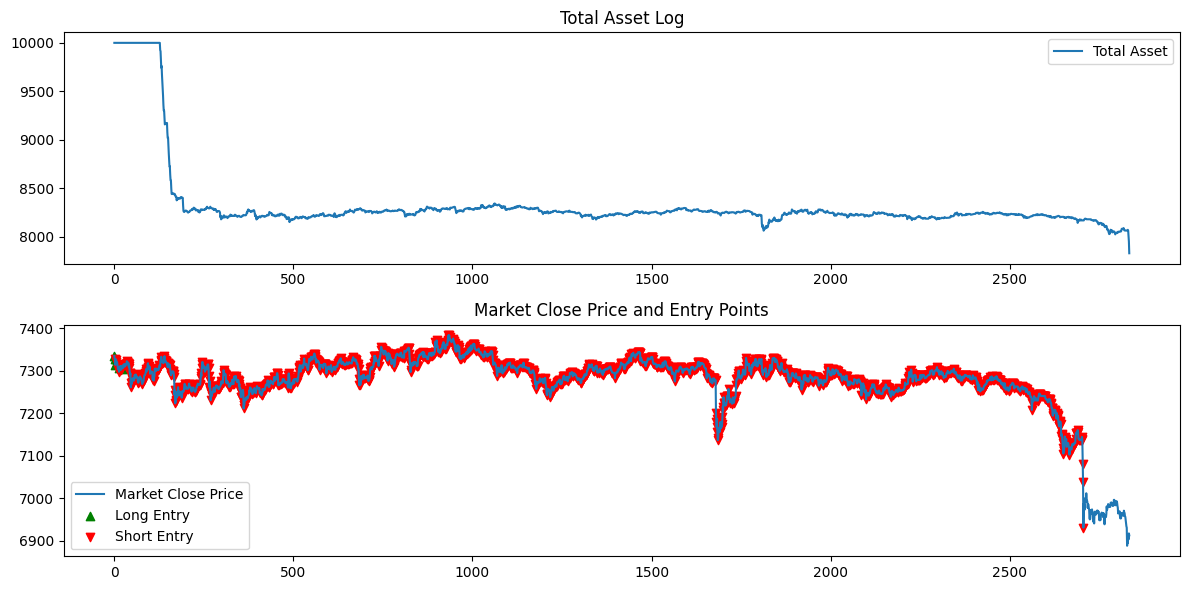

In [39]:
################################################################################
#################################### Read NN Sim #################################
################################################################################
class ReadNNSim:
    def __init__(self, nn_class, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        self.md_state_length = md_state_length
        self.md_state_num = md_state_num
        self.ac_state_length = ac_state_length
        self.ac_state_num = ac_state_num
        self.output_size = output_size
        self.nn_class = nn_class
        self.model = self.nn_class(md_state_length, md_state_num, ac_state_length, ac_state_num, output_size)
        model_state = torch.load(model_directory+"GARL_MarketOrderOnlyModel.pth")
        self.model.load_state_dict(model_state)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def start_sim(self, start_ind, end_ind):
        # トレーディング環境の初期化
        env = TradingEnv(display_flg=True, start_ind=start_ind, end_ind=end_ind, state_length=self.ac_state_length)
        # シミュレーションの設定
        total_steps = end_ind - start_ind
        # To track entry points for plotting
        long_entries, short_entries = [], []
        # シミュレーション実行
        for step in range(total_steps):
            # 現在の状態を取得
            current_index = env.start_ind + step
            md_state = MarketData.generate_state(current_index, md_state_length)
            ac_state = env.generate_state()  # 仮定: __generate_state() は現在のアカウント状態を返す
            # md_stateをモデルの入力形式に変換
            md_state_tensor = torch.FloatTensor([list(md_state.values())]).to(self.device)
            # ac_stateをモデルの入力形式に変換
            ac_state_tensor = torch.FloatTensor([list(ac_state.values())]).to(self.device)
            # NNを使ってアクションを予測
            with torch.no_grad():
                action_probs = self.model(md_state_tensor, ac_state_tensor)
            action_ind = torch.argmax(action_probs).item()  # 最も確率が高いアクションを選択
            # Record entry points
            if action_ind == 1:
                long_entries.append(step)
            elif action_ind == 2:
                short_entries.append(step)
            # トレーディング環境にアクションを適用
            action_ratio = 1.0  # アクション比率の設定（必要に応じて変更）
            is_done, ac_state = env.step(action_ind, action_ratio)
            # シミュレーションの終了判定
            if is_done:
                print('Env is done!')
                break
            else:
                print(f"Step {step}:Action type: {action_ind}, Asset Ratio: {env.total_asset/env.initial_asset:.2f}, Num Trades: {env.num_trade}, Num Wins: {env.num_win}, Win Rate: {env.win_rate:.2f}, Position: Side {env.position_side}, Position Size: {env.position_price * env.position_lot:.2f}, Free Cash: {env.free_cash:.2f}, Lot {env.position_lot:.2f}, Unrealized PnL Ratio: {env.unrealized_pnl_ratio:.2f}, Total Realized PnL: {env.total_realized_pnl:.2f}")
        self.__display(env, long_entries, short_entries)

    def __display(self, env, long_entries, short_entries):
        # 結果の表示（省略）
        # Plotting
        plt.figure(figsize=(12, 6))
        # Plot total asset log
        plt.subplot(2, 1, 1)
        plt.plot(env.total_asset_log, label='Total Asset')
        plt.legend()
        plt.title('Total Asset Log')
        # Plot MarketData.close with long and short entries
        valid_close_data = MarketData.close[env.start_ind:env.start_ind + len(env.total_asset_log)]
        plt.subplot(2, 1, 2)
        plt.plot(valid_close_data, label='Market Close Price')
        # long_entries と short_entries のクローズ価格を取得
        long_close_prices = [MarketData.close[env.start_ind + i] for i in long_entries if env.start_ind + i < len(MarketData.close)]
        short_close_prices = [MarketData.close[env.start_ind + i] for i in short_entries if env.start_ind + i < len(MarketData.close)]
        # エントリポイントをプロット
        plt.scatter(long_entries, long_close_prices, color='green', marker='^', label='Long Entry')
        plt.scatter(short_entries, short_close_prices, color='red', marker='v', label='Short Entry')
        plt.legend()
        plt.title('Market Close Price and Entry Points')
        plt.tight_layout()
        plt.show()



md_state_length = 32
md_state_num = len(MarketData.terms)
ac_state_length = 128
ac_state_num = 2
output_size = 3
sim_start_ind = 20000
sim_end_ind = 1000000
nn_class = SimplifiedMarketOrderModel
sim = ReadNNSim(nn_class, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size)
sim.start_sim(sim_start_ind, sim_end_ind)

In [ ]:
md_out = torch.randn(6, 16)
ac_out = torch.randn(2, 64)
torch.cat([torch.flatten(md_out), torch.flatten(ac_out)])

In [12]:
price * round(amount,2) / price

9587.32